In [ ]:
# **Mengimpor Pustaka yang Diperlukan**

# Untuk manipulasi data dan operasi dataframe
import pandas as pd

# Untuk operasi pencocokan dan manipulasi string menggunakan regex
import re

# Untuk operasi tensor dan model deep learning (PyTorch)
import torch

# Untuk membagi dataset menjadi data latih dan data uji
from sklearn.model_selection import train_test_split

# Untuk evaluasi performa model
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

# Untuk model BERT dan pelatihan model
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Untuk menambahkan progress bar
from tqdm import tqdm

# Untuk melakukan stemming pada teks Bahasa Indonesia
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Untuk mengakses daftar kata berhenti dalam bahasa Inggris (stopwords)
from nltk.corpus import stopwords

# Untuk pengolahan bahasa alami, terutama stopwords dan tokenisasi
import nltk

# Untuk visualisasi grafik
import matplotlib.pyplot as plt

# Untuk visualisasi statistik yang lebih baik dengan seaborn
import seaborn as sns

# Mengimpor library WordCloud untuk membuat visualisasi kata-kata (word cloud)
from wordcloud import WordCloud

# Untuk progress bar
from tqdm import tqdm

# Mengimpor pustaka tambahan untuk model BERT dan optimisasi
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    BertConfig,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    AdamW
)

# Untuk operasi tensor dengan PyTorch
import torch

# Mengunduh stopwords dari nltk (kata-kata yang sering muncul tetapi tidak memberikan informasi penting)
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Michelle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Membaca file CSV yang berisi data dan menyimpannya dalam DataFrame
df = pd.read_csv('C:\\Users\\Michelle\\Downloads\\Projek UAS Industri Data Science\\gabungansentiimen.csv')

# Menampilkan beberapa baris pertama dari DataFrame untuk memverifikasi apakah data berhasil dimuat dengan benar
df.head()


### **EDA**

In [ ]:
# **Exploratory Data Analysis (EDA)**
# Melihat distribusi label 'sentimen' dalam dataset

# Menghitung jumlah kemunculan setiap kategori label dalam kolom 'sentimen'
label_counts = df['sentimen'].value_counts()

# Menampilkan hasil distribusi label
print("Distribusi label:")
print(label_counts)


Distribusi label:
sentimen
positif    1980
netral     1554
negatif    1495
Name: count, dtype: int64


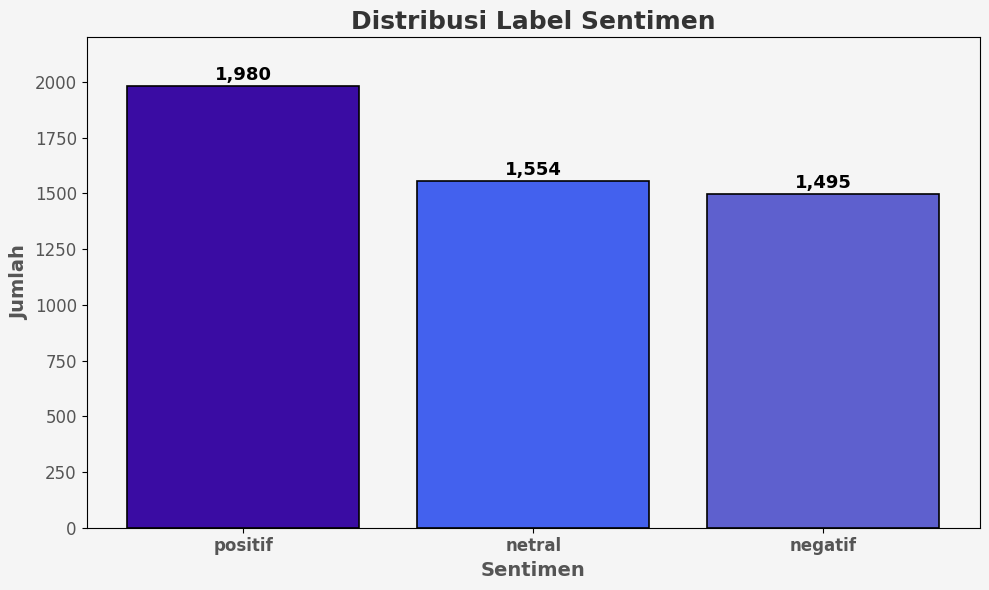

In [ ]:
# Data label_counts: Menyimpan distribusi jumlah label dalam dictionary
label_counts = {'positif': 1980, 'netral': 1554, 'negatif': 1495}

# Mendapatkan label (kategori sentimen) dan nilai (jumlah setiap label)
labels = list(label_counts.keys())
values = list(label_counts.values())

# Menentukan warna untuk batang grafik berdasarkan nilai (terbalik urutan: biru terang untuk nilai kecil, ungu tua untuk nilai besar)
colors = ['#5E60CE', '#4361EE', '#3A0CA3']  # Warna biru terang ke ungu tua, urutkan dari kecil ke besar

# Membuat plot batang untuk menampilkan distribusi label
plt.figure(figsize=(10, 6))  # Ukuran gambar grafik
bars = plt.bar(labels, values, color=colors[::-1], edgecolor='black', linewidth=1.2)  # Membalik urutan warna untuk tampilan

# Menambahkan anotasi jumlah pada setiap batang untuk menunjukkan nilai
for bar in bars:
    yval = bar.get_height()  # Mendapatkan tinggi batang (nilai)
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 30, f"{yval:,}", ha='center', fontsize=13, fontweight='bold', color='black')

# Menambahkan elemen estetika pada grafik
plt.title("Distribusi Label Sentimen", fontsize=18, fontweight='bold', color='#333333')  # Judul grafik
plt.xlabel("Sentimen", fontsize=14, fontweight='bold', color='#555555')  # Label sumbu x
plt.ylabel("Jumlah", fontsize=14, fontweight='bold', color='#555555')  # Label sumbu y
plt.xticks(fontsize=12, fontweight='bold', color='#555555')  # Ukuran dan warna font untuk label sumbu x
plt.yticks(fontsize=12, color='#555555')  # Ukuran dan warna font untuk label sumbu y
plt.ylim(0, 2200)  # Menambahkan jarak di atas batang agar anotasi tidak terpotong
plt.grid(axis='y', linestyle='', alpha=0.6)  # Menambahkan grid hanya pada sumbu y untuk estetika

# Menambahkan latar belakang transparan
plt.gca().set_facecolor('#F5F5F5')  # Mengubah warna latar belakang grafik
plt.gcf().patch.set_facecolor('#F5F5F5')  # Mengubah warna latar belakang figure

# Menampilkan grafik dengan layout yang lebih baik
plt.tight_layout()  # Mengatur layout agar semua elemen pas dan tidak terpotong
plt.show()  # Menampilkan grafik


In [ ]:
# Cek panjang teks pada kolom 'content' dan simpan hasilnya dalam kolom baru 'text_length'
df['text_length'] = df['content'].apply(len)

# Menampilkan statistik deskriptif mengenai panjang teks
print("Statistik panjang teks:")
print(df['text_length'].describe())


Statistik panjang teks:
count    5029.000000
mean       67.213959
std        22.465503
min         4.000000
25%        56.000000
50%        64.000000
75%        74.000000
max       195.000000
Name: text_length, dtype: float64


### **PREPROCESSING**

In [7]:
# Kamus slang dan stopwords
slang_dict = {
    'gak': 'tidak',
    'gk': 'tidak',
    'nggak': 'tidak',
    'aja': 'saja',
    'kalo': 'kalau',
    'yg': 'yang',
    'trs': 'terus',
    'bgt': 'banget',
    'tp': 'tapi',
    'dl': 'dulu',
    'blm': 'belum',
    'udah': 'sudah',
    'udh': 'sudah',
    'jd': 'jadi',
    'dgn': 'dengan'
}

# Fungsi untuk normalisasi slang
def normalize_slang(text):
    words = text.split()
    normalized = [slang_dict[word] if word in slang_dict else word for word in words]
    return ' '.join(normalized)

# Stopwords Bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))
# Pastikan kata penting tetap ada
stop_words -= {'tidak', 'bukan', 'belum', 'jangan', 'kurang', 'namun', 'meskipun', 'sebaliknya', 'malah'}

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi untuk menghapus emoji
def remove_emoji(text):
    emoji_pattern = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Fungsi untuk menangani negasi
def handle_negation(text):
    text = re.sub(r'\b(tidak|bukan|jangan|belum)\s(\w+)', r'\1_\2', text)
    text = re.sub(r'\b(tidak|bukan|jangan|belum)\s(\w+)\s(\w+)', r'\1_\2_\3', text)
    return text

# Fungsi untuk proses pembersihan teks
def clean_text_advanced(text):
    # Normalisasi slang
    text = normalize_slang(text)

    # Hapus emoji
    text = remove_emoji(text)

    # Hapus simbol dan karakter khusus lainnya
    text = re.sub(r'[^\w\s]', '', text)

    # Deteksi dan tangani negasi
    text = handle_negation(text)

    # Hapus URL
    text = re.sub(r'http\S+', '', text)

    # Hapus angka
    text = re.sub(r'\d+', '', text)

    # Hapus huruf yang berulang lebih dari 2 kali (contoh: baguuuuus -> bagus)
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Ubah teks ke huruf kecil
    text = text.lower()

    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    # Hapus stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Stemming
    text = stemmer.stem(text)
    
    return text

# Terapkan pembersihan teks pada DataFrame
df['cleaned_content'] = df['content'].apply(clean_text_advanced)


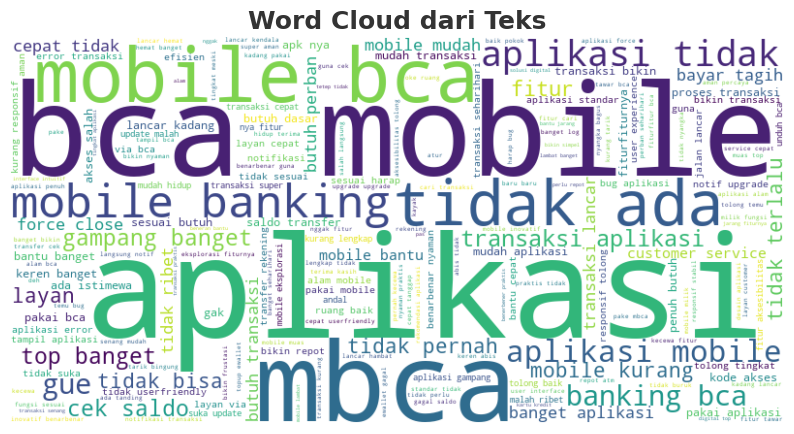

In [ ]:
# Gabungkan semua teks dari cleaned_content
all_text = " ".join(df['cleaned_content'])

# Konfigurasi WordCloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis',  # Skema warna
    max_words=200  # Maksimal kata yang ditampilkan
).generate(all_text)

# Plot WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hilangkan sumbu
plt.title("Word Cloud dari Teks",  fontsize=18, fontweight='bold', color='#333333')
plt.show()


In [8]:
# Mapping label ke angka: positif = 2, netral = 1, negatif = 0
sentiment_mapping = {'negatif': 0, 'netral': 1, 'positif': 2}
df['label'] = df['sentimen'].map(sentiment_mapping)


In [ ]:
# Membagi data menjadi set pelatihan dan set validasi (80% pelatihan, 20% validasi)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['cleaned_content'].tolist(),  # Daftar teks yang sudah dibersihkan
    df['label'].tolist(),  # Daftar label untuk setiap teks
    test_size=0.2,  # Proporsi data untuk validasi adalah 20%
    random_state=42  # Menetapkan seed acak agar pembagian data dapat direproduksi
)

In [ ]:
# **Tokenization dengan IndoBERT**

# Menentukan nama model BERT yang akan digunakan, dalam hal ini IndoBERT
model_name = "indobenchmark/indobert-base-p1"

# Memuat tokenizer dari model yang sudah dilatih (pre-trained) IndoBERT
tokenizer = BertTokenizer.from_pretrained(model_name)

# Melakukan tokenisasi pada teks pelatihan dan validasi
# Tokenisasi ini juga akan mengurangi panjang teks jika lebih panjang dari max_length dan menambah padding jika lebih pendek
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=64)

# Konversi hasil tokenisasi menjadi dataset PyTorch
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings  # Menyimpan hasil tokenisasi
        self.labels = labels  # Menyimpan label sentimen

    # Fungsi untuk mengambil item data pada indeks tertentu
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}  # Mengubah token menjadi tensor
        item['labels'] = torch.tensor(self.labels[idx])  # Menambahkan label sentimen sebagai tensor
        return item

    # Fungsi untuk mendapatkan panjang dataset
    def __len__(self):
        return len(self.labels)

# Membuat dataset pelatihan dan validasi dari hasil tokenisasi
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)


In [ ]:
# Mencetak tipe objek dari train_dataset untuk memverifikasi apakah itu merupakan instance dari SentimentDataset
print(type(train_dataset))

# Mencetak elemen pertama dari train_dataset untuk memeriksa struktur datanya
print(train_dataset[0])  # Periksa elemen pertama untuk memahami strukturnya


<class '__main__.SentimentDataset'>
{'input_ids': tensor([    2,   933,     5,  3807,  8320,  5872,  1057, 20366,  3854,  1181,
            3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'labels': tensor(0)}


In [ ]:
# Memastikan panjang data label sama dengan panjang token input untuk data pelatihan
assert len(train_labels) == len(train_encodings['input_ids']), "Mismatch in training data length!"

# Memastikan panjang data label sama dengan panjang token input untuk data validasi
assert len(val_labels) == len(val_encodings['input_ids']), "Mismatch in validation data length!"


### **FINE-TUNING MODEL**

In [ ]:
# **Konfigurasi Model**

# Menyiapkan konfigurasi untuk model BERT, dengan penambahan beberapa parameter untuk regularisasi
config = BertConfig.from_pretrained(
    model_name,
    num_labels=3,  # Menentukan jumlah label (sentimen positif, netral, dan negatif)
    hidden_dropout_prob=0.5,  # Dropout untuk mencegah overfitting
    attention_probs_dropout_prob=0.5  # Dropout pada attention layer untuk stabilitas pelatihan
)

# Memuat model BERT untuk klasifikasi sekuens dengan konfigurasi yang sudah disesuaikan
model = BertForSequenceClassification.from_pretrained(model_name, config=config)

# **Metrik Evaluasi**

# Fungsi untuk menghitung metrik evaluasi
def compute_metrics(pred):
    labels = pred.label_ids  # Label asli
    preds = pred.predictions.argmax(-1)  # Prediksi dari model (ambil indeks dengan probabilitas tertinggi)
    # Menghitung precision, recall, f1-score dengan rata-rata tertimbang
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)  # Akurasi
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# **Custom Optimizer**

# Menyiapkan optimizer AdamW dengan parameter-parameter yang sudah diatur
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# **Training Arguments**

# Menyusun argumen untuk pelatihan, yang meliputi pengaturan output, batch size, dan lainnya
training_args = TrainingArguments(
    output_dir='./results',             # Direktori output untuk menyimpan hasil model
    num_train_epochs=1,                 # Jumlah epoch pelatihan (hanya 1 untuk eksperimen awal)
    per_device_train_batch_size=8,      # Ukuran batch untuk pelatihan per perangkat (misalnya GPU)
    per_device_eval_batch_size=8,       # Ukuran batch untuk evaluasi
    warmup_steps=300,                   # Jumlah langkah untuk warm-up learning rate scheduler
    max_grad_norm=1.0,                  # Gradient clipping untuk mencegah gradien eksplosif
    learning_rate=3e-5,                 # Learning rate yang digunakan
    weight_decay=0.01,                  # Regularisasi untuk mencegah overfitting
    logging_dir='./logs',               # Direktori untuk menyimpan file log
    logging_steps=10,                   # Frekuensi untuk mencatat log
    evaluation_strategy="epoch",        # Evaluasi di akhir setiap epoch
    save_strategy="epoch",              # Simpan model di akhir setiap epoch
    save_total_limit=1,                 # Batasi jumlah checkpoint yang disimpan (hanya 1)
    load_best_model_at_end=True,        # Muat model terbaik setelah pelatihan selesai
    fp16=True,                          # Gunakan mixed precision untuk efisiensi memori dan kecepatan
    report_to="none",                   # Nonaktifkan laporan ke platform eksternal (misalnya TensorBoard)
)

# **Trainer**

# Menyiapkan objek Trainer dengan model, argumen pelatihan, dataset, tokenizer, dan metrik evaluasi
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Dataset pelatihan
    eval_dataset=val_dataset,     # Dataset validasi
    tokenizer=tokenizer,          # Tokenizer yang digunakan untuk memproses teks
    compute_metrics=compute_metrics,  # Fungsi untuk menghitung metrik
    optimizers=(optimizer, None)  # Optimizer custom, dan kita tidak menggunakan scheduler di sini
)

# **Early Stopping**

# Menambahkan callback untuk early stopping (berhenti lebih awal jika tidak ada perbaikan)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=1))  # Berhenti jika tidak ada perbaikan dalam 1 epoch

# **Pelatihan**

# Memulai proses pelatihan model dengan dataset pelatihan dan evaluasi yang sudah disiapkan
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Michelle\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\Michelle\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Michelle\AppData\Local\Temp\ipykernel_29276\903102948.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.

  0%|          | 0/503 [00:00<?, ?it/s]

{'loss': 1.1225, 'grad_norm': 18.82347297668457, 'learning_rate': 1.6666666666666667e-06, 'epoch': 0.02}
{'loss': 1.1619, 'grad_norm': 19.84223175048828, 'learning_rate': 3.3333333333333333e-06, 'epoch': 0.04}
{'loss': 1.1182, 'grad_norm': 18.36553955078125, 'learning_rate': 5e-06, 'epoch': 0.06}
{'loss': 1.1389, 'grad_norm': 18.84559440612793, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.08}
{'loss': 1.1417, 'grad_norm': 16.8276424407959, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.1}
{'loss': 1.0789, 'grad_norm': 18.857330322265625, 'learning_rate': 1e-05, 'epoch': 0.12}
{'loss': 1.1016, 'grad_norm': 17.6418514251709, 'learning_rate': 1.1666666666666668e-05, 'epoch': 0.14}
{'loss': 1.0834, 'grad_norm': 17.601566314697266, 'learning_rate': 1.3333333333333333e-05, 'epoch': 0.16}
{'loss': 1.079, 'grad_norm': 16.28187370300293, 'learning_rate': 1.5e-05, 'epoch': 0.18}
{'loss': 1.0958, 'grad_norm': 17.95230484008789, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.2}
{'lo

  0%|          | 0/126 [00:00<?, ?it/s]

{'eval_loss': 0.35776618123054504, 'eval_accuracy': 0.9234592445328031, 'eval_f1': 0.9233492548345477, 'eval_precision': 0.9269422359401615, 'eval_recall': 0.9234592445328031, 'eval_runtime': 54.1093, 'eval_samples_per_second': 18.592, 'eval_steps_per_second': 2.329, 'epoch': 1.0}
{'train_runtime': 1221.4172, 'train_samples_per_second': 3.294, 'train_steps_per_second': 0.412, 'train_loss': 0.6670197807770837, 'epoch': 1.0}


TrainOutput(global_step=503, training_loss=0.6670197807770837, metrics={'train_runtime': 1221.4172, 'train_samples_per_second': 3.294, 'train_steps_per_second': 0.412, 'total_flos': 66156579969984.0, 'train_loss': 0.6670197807770837, 'epoch': 1.0})

In [ ]:
# **Evaluasi Model**

# Melakukan evaluasi pada model menggunakan dataset validasi yang telah dipersiapkan
results = trainer.evaluate()

# Menampilkan hasil evaluasi
print("Hasil evaluasi model:")
print(results)


  0%|          | 0/126 [00:00<?, ?it/s]

Hasil evaluasi model:
{'eval_loss': 0.35776618123054504, 'eval_accuracy': 0.9234592445328031, 'eval_f1': 0.9233492548345477, 'eval_precision': 0.9269422359401615, 'eval_recall': 0.9234592445328031, 'eval_runtime': 54.3557, 'eval_samples_per_second': 18.508, 'eval_steps_per_second': 2.318, 'epoch': 1.0}


In [ ]:
# **Evaluasi Model pada Data Validasi**

# Melakukan evaluasi pada model menggunakan dataset validasi yang telah dipersiapkan
results = trainer.evaluate()

# Menampilkan akurasi dan F1 score hasil evaluasi
print(f"Validation Accuracy: {results['eval_accuracy']}")
print(f"Validation F1 Score: {results['eval_f1']}")


  0%|          | 0/126 [00:00<?, ?it/s]

Validation Accuracy: 0.9234592445328031
Validation F1 Score: 0.9233492548345477


In [ ]:
# **Evaluasi Manual pada Dataset Validasi**

# Melakukan prediksi pada dataset validasi menggunakan trainer
val_preds = trainer.predict(val_dataset)

# Menghitung prediksi dengan mengambil argmax dari hasil prediksi untuk menentukan label kelas
val_pred_labels = torch.argmax(torch.tensor(val_preds.predictions), dim=1).numpy()

# Menampilkan classification report
print("Classification Report pada Dataset Validasi:")
print(classification_report(val_labels, val_pred_labels, target_names=['negatif', 'netral', 'positif']))


  0%|          | 0/126 [00:00<?, ?it/s]

Classification Report pada Dataset Validasi:
              precision    recall  f1-score   support

     negatif       0.86      0.97      0.91       274
      netral       0.96      0.86      0.91       328
     positif       0.94      0.95      0.95       404

    accuracy                           0.92      1006
   macro avg       0.92      0.92      0.92      1006
weighted avg       0.93      0.92      0.92      1006



In [ ]:
# 1. Load dataset tidak berlabel
df_unlabeled = pd.read_csv("C:\\Users\\Michelle\\Downloads\\Projek UAS Industri Data Science\\data_bca_10k.csv")  # Dataset tidak berlabel dengan kolom 'content'

# 2. Preprocessing dataset tidak berlabel
df_unlabeled['cleaned_content'] = df_unlabeled['content'].apply(clean_text_advanced)

# 3. Batasi ukuran batch untuk proses prediksi
batch_size = 8  # Mengurangi batch size jika kapasitas terbatas
predicted_labels = []

# 4. Prediksi dalam batch
for i in tqdm(range(0, len(df_unlabeled), batch_size)):
    # Ambil batch teks
    batch_texts = df_unlabeled['cleaned_content'].iloc[i:i + batch_size].tolist()

    # Tokenisasi batch
    encodings = tokenizer(batch_texts, truncation=True, padding=True, max_length=64, return_tensors="pt")
    encodings = {key: val.to('cuda' if torch.cuda.is_available() else 'cpu') for key, val in encodings.items()}  # Pindahkan ke GPU jika tersedia

    # Prediksi batch dengan no_grad untuk menghemat memori
    with torch.no_grad():
        outputs = model(**encodings)
        batch_predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Ambil prediksi

    # Simpan hasil prediksi
    predicted_labels.extend(batch_predictions)

# 5. Tambahkan hasil prediksi ke dataset
df_unlabeled['predicted_label'] = predicted_labels


100%|██████████| 1250/1250 [03:13<00:00,  6.46it/s]


In [19]:
# Mapping angka ke label sentimen
reverse_sentiment_mapping = {0: 'negatif', 1: 'netral', 2: 'positif'}
df_unlabeled['predicted_sentimen'] = df_unlabeled['predicted_label'].map(reverse_sentiment_mapping)


In [ ]:
# # Simpan hasil prediksi
# df_unlabeled.to_csv('data_unlabeled_with_predictions.csv', index=False)

### **TESTING**

In [37]:
# Prediksi satu kali saja
user_input = input("Masukkan teks untuk dianalisis: ")

# Preprocessing input user
cleaned_input = clean_text_advanced(user_input)

# Tokenisasi input
inputs = tokenizer(cleaned_input, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Prediksi sentimen
outputs = model(**inputs)
predicted_label = torch.argmax(outputs.logits, dim=1).item()

# Mapping label ke sentimen
predicted_sentimen = reverse_sentiment_mapping[predicted_label]
print(f"Sentimen: {predicted_sentimen}")


Sentimen: netral


In [32]:
# Direktori untuk menyimpan model
output_dir = "./saved_model"

# Simpan model
model.save_pretrained(output_dir)

# Simpan tokenizer
tokenizer.save_pretrained(output_dir)

print(f"Model dan tokenizer berhasil disimpan di: {output_dir}")


Model dan tokenizer berhasil disimpan di: ./saved_model
